# Join 平台眾開講

Things tried so far:

* Single hidden dense layer model

A few things to try next:

* RNN, since the comments tend to be short and paragraph-less.
* CNN
* fastText

## Setup

In [49]:
path = "data/join"
topic = "立法方式保障"
# topic = "同性伴侣法"
# topic = "同性婚姻法"

In [50]:
from __future__ import division, print_function
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import jieba
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout
import os, math

Read in messages from CSV.

In [51]:
def get_messages_from_orig(topic):
    messages = pd.read_csv(os.path.join(path, topic + ".csv"), index_col=0)
    mask = messages.astype('str').applymap(lambda x: len(x.decode('utf-8'))).content > 20
    messages = messages[mask]
    messages.to_csv(os.path.join(path, topic + "-good.csv"))
    return messages

def get_labeled_messages(topic):
    return pd.read_csv(os.path.join(path, topic + "-good.csv"), index_col=0)

def labeled_only(messages):
    return messages[messages.ORID.notnull()]

def unlabeled_only(messages):
    return messages[messages.ORID.isnull()]
    
all_messages = get_messages_from_orig(topic) if not os.path.exists(os.path.join(path, topic + "-good.csv")) \
                                         else get_labeled_messages(topic)
print("Total messages: {count}".format(count=len(all_messages)))
messages = labeled_only(all_messages)
print("Labeled messages: {count}".format(count=len(messages)))
messages.head()

Total messages: 10215
Labeled messages: 63


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


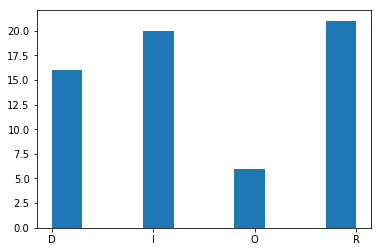

In [52]:
plt.hist(messages.ORID.values)
plt.show()

Build dictionary of phrases and load word embeddings.

In [53]:
def write_dictionary(messages):
    contents = [ jieba.lcut(c) for c in messages.content ]
    all_phrases = set([ ph for c in contents for ph in c ])
    with open(os.path.join(path, "dictionary.txt"), "w") as fh:
        for ph in all_phrases:
            fh.write(ph.encode("utf-8") + "\n")
            
def read_dictionary():
    dictionary = pd.read_csv(os.path.join(path, "dictionary.vec"), 
                       delim_whitespace=True, engine="python", header=None, index_col=0)
    return dictionary

if not os.path.exists("dictionary.vec"):
    write_dictionary(all_messages)
    !cd data/join; ../../../bin/fasttext print-word-vectors models/wiki.zh.bin < dictionary.txt > dictionary.vec
dictionary = read_dictionary()
dictionary.shape

(44956, 300)

Build dictionary index to convert phrases into embedding vectors.

In [54]:
dict_index = { ph.decode("utf-8"): i for i, ph in enumerate(dictionary.index) }
dict_index[u"同性"], (dictionary.iloc[dict_index[u"同性"]] == dictionary.loc["同性"]).all()

(35102, True)

Split messages into training and validation datasets.

In [55]:
select = np.random.random(len(messages)) < 0.9
train = messages[select]
valid = messages[~select]

In [56]:
print("Training data: {count}".format(count=len(train)))
train.head()

Training data: 61


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN
14131,2015-08-03 10:21:00,Janus Chang,讓更多人可以結婚到底有甚麼問題???? 一堆拿幾千年前教條來干預現代人生活的人真的是社會的敗類。,R,NaN
14130,2015-08-03 13:06:12,Thomas Chen,支持婚姻平權.一步到位.台灣並不以宗教立國.人民有人民的格調.請政府跟上我们的腳步.如果我们...,D,NaN


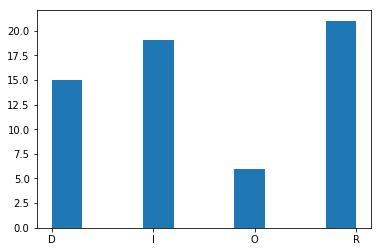

In [57]:
plt.hist(train.ORID.values)
plt.show()

In [58]:
print("Validation data: {count}".format(count=len(valid)))
valid.head()

Validation data: 2


,createDate,authorName,content,ORID,comments
id,,,,,
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN


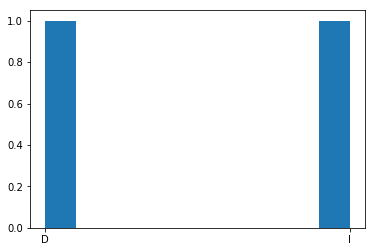

In [59]:
plt.hist(valid.ORID.values)
plt.show()

Setup input length and word embeddings.

In [60]:
input_length = 50

def create_embeddings(dictionary, input_length=100):
    phrases, latents = dictionary.shape
    embedding = Embedding(phrases, latents, input_length=input_length, weights=[dictionary])
    return embedding

In [61]:
def get_data(messages):
    jieba_cut = np.frompyfunc(lambda x: [ ph for ph in jieba.lcut(x.decode("utf-8")) if ph != u" " ][:input_length], 1, 1)
    word_embed = np.frompyfunc(lambda x: [ dict_index[ph] for ph in x ], 1, 1)
    fill_to_length = np.frompyfunc(lambda x: x + [0] * (input_length - len(x)), 1, 1)
    return np.stack(fill_to_length(word_embed(jieba_cut(messages.content.values))), axis=0)

answers_oh = { "O": [1., 0., 0., 0.], "R": [0., 1., 0., 0.], "I": [0., 0., 1., 0.], "D": [0., 0., 0., 1.] }

def get_answer(messages):
    return np.array([ answers_oh[x] for x in messages.ORID ])

train = (get_data(train), get_answer(train))
valid = (get_data(valid), get_answer(valid))

In [62]:
train[0][10], train[1][10], valid[0][0], valid[1][0]

(array([31043, 34648, 39303, 37630, 19941, 24467,  4530,  5442,  4414,
        42524, 28133, 23894, 42356, 20923,  4530, 18210,  9313, 42934,
        31739, 20923, 14634, 37630, 38922, 31103, 36659,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([ 0.,  0.,  0.,  1.]),
 array([39403, 32677, 39403, 42769,  4633, 29511, 12334, 43158, 37630,
        27354, 11541, 17352, 16739, 44472, 35071, 12361,  8186, 42918,
         4414, 33073, 17642,  7730, 32030, 19321, 40323, 22601, 27041,
        24903, 43183, 34376,  4414, 23626,  5442,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([ 0.,  0.,  0.,  1.]))

# Single hidden layer model

In [28]:
batch_size = 64

def linear_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.6))
    model.add(Dense(4, activation="softmax"))
    return model

linear = linear_model()
linear.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 50, 300)       13486800    embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 15000)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           7680512     flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           dense_1[0][0]                    
___________________________________________________________________________________________

In [29]:
linear.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
def train_linear(lr=None, epoch=1):
    if lr is not None:
        linear.optimizer.lr = lr
    linear.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)
    
train_linear()

Train on 59 samples, validate on 4 samples
Epoch 1/1
59/59 [==============================] - 0s - loss: 1.8750 - acc: 0.1864 - val_loss: 11.6880 - val_acc: 0.2500


In [21]:
train_linear(lr=0.1, epoch=2)
train_linear(lr=0.01, epoch=4)
train_linear(lr=0.001, epoch=4)

Train on 59 samples, validate on 4 samples
Epoch 1/2
59/59 [==============================] - 0s - loss: 9.6479 - acc: 0.3220 - val_loss: 8.4339 - val_acc: 0.2500
Epoch 2/2
59/59 [==============================] - 0s - loss: 8.1080 - acc: 0.3051 - val_loss: 6.1407 - val_acc: 0.5000
Train on 59 samples, validate on 4 samples
Epoch 1/4
59/59 [==============================] - 0s - loss: 8.7672 - acc: 0.3220 - val_loss: 6.2506 - val_acc: 0.5000
Epoch 2/4
59/59 [==============================] - 0s - loss: 7.6085 - acc: 0.3559 - val_loss: 4.0749 - val_acc: 0.7500
Epoch 3/4
59/59 [==============================] - 0s - loss: 4.9033 - acc: 0.4915 - val_loss: 4.7415 - val_acc: 0.0000e+00
Epoch 4/4
59/59 [==============================] - 0s - loss: 5.4848 - acc: 0.4407 - val_loss: 7.8911 - val_acc: 0.2500
Train on 59 samples, validate on 4 samples
Epoch 1/4
59/59 [==============================] - 0s - loss: 5.1637 - acc: 0.4915 - val_loss: 9.2897 - val_acc: 0.2500
Epoch 2/4
59/59 [==========

# Evaluation

In [17]:
model = linear

In [18]:
unlabeled = unlabeled_only(all_messages)
test_data = get_data(unlabeled)

In [19]:
pred = model.predict(test_data, batch_size=batch_size)

In [20]:
unlabeled.head(10)

,createDate,authorName,content,ORID,comments
id,,,,,
14138,2015-08-03 8:12:21,小K,那麼亞洲國家的現況呢？以新加坡或日本這兩個已開發的國家來說，是否有進行相關政策？,NaN,NaN
14110,2015-08-04 2:41:32,Oliver Lin,你搞錯了，不論性向有錢人是最不受制度限制的一群人如果你擔心這點，請採用共產制度根本上讓大家均貧就好,NaN,NaN
14103,2015-08-04 3:43:13,in.j li,"你(妳)知道性取向是天生的,那試問, 如果自然法則是同性交配才能繁殖下一代, 那你(妳)可以...",NaN,NaN
14097,2015-08-04 4:29:26,black756133,無神論者無法相信任何沒有存在證據的神說的話，跟神溝通也只能透過古代人編寫的各種版本同人作品自...,NaN,NaN
14096,2015-08-04 4:33:21,RED,冰山一角http://news.ltn.com.tw/news/wo...,NaN,NaN
14088,2015-08-04 5:21:16,RED,網路很多新聞，平時你不看的那種。https://chinesemanif.wordpress...,NaN,NaN
14086,2015-08-04 5:22:52,炎暴龍,不支持不適用於異性戀的伴侶法！此議題的命題方式已嚴重歧視各性向的族群我支持可適用於全民的伴侶...,NaN,NaN
14085,2015-08-04 5:27:30,I-Ling Yeh,婚姻和伴侶關係應是獨立兩種關係，兩者都不應因為對象的性別受限。認可同性婚姻應直接在民法明文說...,NaN,NaN
14083,2015-08-04 5:33:41,Jun-Yuan Guo,「隔離而平等不是真平等」我支持修改民法，還給同志族群與異性戀者相同的婚姻權和親權；並新增相關...,NaN,NaN


In [21]:
pred[:10]

array([[  2.33472145e-38,   3.96522671e-01,   6.03477359e-01,
          4.94881489e-37],
       [  0.00000000e+00,   9.99618769e-01,   3.81167250e-04,
          0.00000000e+00],
       [  1.31799101e-32,   9.99994159e-01,   5.82005259e-06,
          3.91706221e-32],
       [  3.62049274e-31,   9.99779761e-01,   2.20267350e-04,
          3.46005305e-31],
       [  9.84984932e-37,   9.08753090e-03,   9.90912437e-01,
          7.28294228e-36],
       [  8.88519972e-38,   1.80057094e-01,   8.19942892e-01,
          9.98887517e-37],
       [  1.47125918e-36,   9.99647141e-01,   3.52818635e-04,
          1.06983474e-35],
       [  6.70091965e-32,   9.95061934e-01,   4.93810000e-03,
          9.72486100e-31],
       [  6.39575915e-35,   9.98556316e-01,   1.44370634e-03,
          1.07126428e-33],
       [  1.16256888e-29,   9.90411043e-01,   9.58895311e-03,
          2.20837434e-29]], dtype=float32)